<a href="https://colab.research.google.com/github/BahatiKilongo/GDA_Live_coding_FML23/blob/main/competition_computervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Start Runing

In [ ]:
#Imports
import os
import sys
import glob
import torch
import torchvision

import numpy    as np
import datetime as dt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot   as plt

from PIL               import Image
from torch.utils.data  import Dataset
from torch.autograd    import Variable
from torch.optim       import lr_scheduler

from torch.utils.data  import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision       import transforms, datasets, models
from os                import listdir, makedirs, getcwd, remove
from os.path           import isfile, join, abspath, exists, isdir, expanduser

%matplotlib inline

In [ ]:
data_path = "/kaggle/input/ammi-2023-convnets"
train_path = join(data_path, "train/train")
test_path = join(data_path,"test/test")
extraimage_path = join(data_path, "extraimages/extraimages")

In [ ]:
# Transformations for both the training and testing data
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training data transformations
train_transforms = transforms.Compose(    
    [
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(512),
    transforms.RandomHorizontalFlip(0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    transforms.RandomErasing(0.3)
])

# Testing data transformations
test_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


In [ ]:
class CassavaDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform

        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)

        return im, classCategory


In [ ]:
train_data = CassavaDataset(train_path, transform=train_transforms)
test_data = CassavaDataset(test_path, transform=test_transforms)

In [ ]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [ ]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=8,
                                             sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=8,
                                             sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8)

### Rensnet 50

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.utils.prune as prune

class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.num_classes = num_classes
        self.model = models.resnet50(pretrained=False)
        
        # Apply quantization to the model
        self.model = torch.quantization.quantize_dynamic(
            self.model, {nn.Conv2d, nn.Linear}, dtype=torch.qint8
        )
        
        # Prune the model to remove unimportant connections
        self.model = self.prune_model(self.model)
        
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, input):
        return self.model(input)
    
    def prune_model(self, model):
        parameters_to_prune = []
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                parameters_to_prune.append((module, 'weight'))
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=0.5
        )
        return model

### Efficient Net

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=a97cc804b3dca1e827550f8ff9c4f428dfe96b46f2c674d9366342afc2f52324
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.num_classes = num_classes
        
        # Load the pretrained EfficientNet model
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        
        # Replace the classifier head with a new one
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, input):
        return self.model(input)

In [ ]:
model = Classifier(5)
# criterion = torch.nn.CrossEntropyLoss()
# #optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 170MB/s]


Loaded pretrained weights for efficientnet-b0


In [ ]:
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# Define the number of epochs
#num_epochs = 10

# Move the model and criterion to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [ ]:
# def train(model, criterion, data_loader, optimizer, num_epochs):
#     """Simple training loop for a PyTorch model.""" 
    
#     # Make sure model is in training mode.
#     model.train()
    
#     # Move model to the device (CPU or GPU).
#     model.to(device)
    
#     # Exponential moving average of the loss.
#     ema_loss = None

#     print('----- Training Loop -----')
#     # Loop over epochs.
#     for epoch in range(num_epochs):
        
#       # Loop over data.
#       for batch_idx, (features, target) in enumerate(data_loader):
            
#           # Forward pass.
#         output = model(features.to(device))
#         loss = criterion(output.to(device), target.to(device))

#           # Backward pass.
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#       # NOTE: It is important to call .item() on the loss before summing.
#         if ema_loss is None:
#             ema_loss = loss.item()
#         else:
#             ema_loss += (loss.item() - ema_loss) * 0.01 

#       # Print out progress the end of epoch.
#       print('Epoch: {} \tLoss: {:.6f}'.format(epoch, ema_loss),)

In [ ]:
import matplotlib.pyplot as plt

def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model.""" 
    
    # Make sure model is in training mode.
    model.train()
    
    # Move model to the device (CPU or GPU).
    model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None
    
    # List to store the losses for each epoch.
    losses = []

    print('----- Training Loop -----')
    # Loop over epochs.
    for epoch in range(num_epochs):
        
        # Loop over data.
        for batch_idx, (features, target) in enumerate(data_loader):
            
            # Forward pass.
            output = model(features.to(device))
            loss = criterion(output.to(device), target.to(device))

            # Backward pass.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update exponential moving average of the loss.
            if ema_loss is None:
                ema_loss = loss.item()
            else:
                ema_loss += (loss.item() - ema_loss) * 0.01

        # Print out progress at the end of epoch.
        print('Epoch: {} \tLoss: {:.6f}'.format(epoch, ema_loss))

        # Append the current epoch's loss to the list.
        losses.append(ema_loss)
#         return losses
    # Plot the losses.
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()


### Traing with K-fold

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from sklearn.model_selection import KFold
# from efficientnet_pytorch import EfficientNet

# def train(model, criterion, data_loader, optimizer, num_epochs):
#     """Training loop with cross-validation for a PyTorch model.""" 

#     # Move model to the device (CPU or GPU).
#     model.to(device)
    
#     # Exponential moving average of the loss.
#     ema_loss = None

#     print('----- Training Loop -----')
    
#     # Define the number of folds for cross-validation.
#     num_folds = 5
    
#     # Split the dataset into folds.
#     kfold = KFold(n_splits=num_folds)
    
#     # Initialize lists to store losses for plotting.
#     train_losses = []
#     val_losses = []
    
#     # Loop over epochs.
#     for epoch in range(num_epochs):
        
#         # Perform cross-validation within each epoch.
#         for fold, (train_indices, val_indices) in enumerate(kfold.split(data_loader.dataset)):
#             # Create data loaders for the training and validation sets.
#             train_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=data_loader.batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
#             val_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=data_loader.batch_size, sampler=torch.utils.data.SubsetRandomSampler(val_indices))
            
#             print('Epoch: {}, Fold: {}'.format(epoch, fold))
            
#             # Create a new instance of the model for each fold.
#             model = Classifier(num_classes=model.num_classes)
            
#             # Move the new model instance to the device.
#             model.to(device)
            
#             # Set the model to training mode.
#             model.train()
            
#             # Initialize the optimizer for each fold.
#             optimizer = optim.Adam(model.parameters())
            
#             # Loop over data in the training set.
#             for batch_idx, (features, target) in enumerate(train_loader):
#                 # Move the features and target to the device.
#                 features = features.to(device)
#                 target = target.to(device)
                
#                 # Forward pass.
#                 output = model(features)
#                 loss = criterion(output, target)

#                 # Backward pass.
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#                 # Update the exponential moving average of the loss.
#                 if ema_loss is None:
#                     ema_loss = loss.item()
#                 else:
#                     ema_loss += (loss.item() - ema_loss) * 0.01 
            
#             # Calculate the validation loss.
#             val_loss = 0.0
#             num_val_batches = 0
            
#             # Set the model to evaluation mode.
#             model.eval()
            
#             # Loop over data in the validation set.
#             with torch.no_grad():
#                 for val_batch_idx, (val_features, val_target) in enumerate(val_loader):
#                     # Move the validation features and target to the device.
#                     val_features = val_features.to(device)
#                     val_target = val_target.to(device)
                    
#                     val_output = model(val_features)
#                     val_loss += criterion(val_output, val_target).item()
#                     num_val_batches += 1
            
#             # Compute the average validation loss.
#             val_loss /= num_val_batches
            
#             # Set the model back to training mode.
#             model.train()
            
#             # Store the losses for plotting.
#             train_losses.append(ema_loss)
#             val_losses.append(val_loss)
            
#             # Print out the training and validation losses.
# #             print('Epoch: {} \tFold: {} \tTrain Loss: {:.6f}
#             # Print out the training and validation losses.
#             print('Epoch: {} \tFold: {} \tTrain Loss: {:.6f} \tVal Loss: {:.6f}'.format(epoch, fold, ema_loss, val_loss))


#     # Plot the loss curves.
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(val_losses, label='Val Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()


In [ ]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        
        # Loop over test data.
        for features, target in data_loader:
          
            # Forward pass.
            output = model(features.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()
    # Print test accuracy.
    percent = 100. * correct / len(valid_sampler)
    print(f'Test accuracy: {correct} / {len(valid_sampler)} ({percent:.0f}%)')
    torch.save(model.state_dict(), 'model.ckpt')
    return percent

### test with losses

In [ ]:
# import torch

# def test(model, data_loader):
#     """Measures the accuracy and losses of a model on a data set.""" 
#     # Make sure the model is in evaluation mode.
    
#     model.eval()
#     correct = 0
#     total_loss = 0.0
#     print('----- Model Evaluation -----')
#     # We do not need to maintain intermediate activations while testing.
#     with torch.no_grad():
#         # Loop over test data.
#         for features, target in data_loader:
#             # Forward pass.
#             output = model(features.to(device))
#             loss_fn=criterion(output, target)
#             # Calculate the loss.
#             loss = loss_fn(output, target.to(device))
            
#             # Accumulate the total loss.
#             total_loss += loss.item() * features.size(0)
            
#             # Get the label corresponding to the highest predicted probability.
#             pred = output.argmax(dim=1, keepdim=True)
            
#             # Count number of correct predictions.
#             correct += pred.cpu().eq(target.view_as(pred)).sum().item()
    
#     # Calculate the average loss.
#     avg_loss = total_loss / len(data_loader.dataset)
    
#     # Print test accuracy and loss.
#     percent = 100. * correct / len(data_loader.dataset)
#     print(f'Test accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)')
#     print(f'Average loss: {avg_loss:.4f}')
    
#     torch.save(model.state_dict(), 'model.ckpt')
    
#     return percent, avg_loss


In [ ]:
# num_epochs = 10
# losses=train(model, criterion, train_loader, optimizer, num_epochs=num_epochs)
# percent, avg_loss=test(model, valid_loader)

----- Training Loop -----
Epoch: 0 	Loss: 0.653557
Epoch: 1 	Loss: 0.595908
Epoch: 2 	Loss: 0.614920
Epoch: 3 	Loss: 0.538007
Epoch: 4 	Loss: 0.527225
Epoch: 5 	Loss: 0.480270
Epoch: 6 	Loss: 0.500837
Epoch: 7 	Loss: 0.423419
Epoch: 8 	Loss: 0.431046
Epoch: 9 	Loss: 0.447668
Epoch: 10 	Loss: 0.423716
Epoch: 11 	Loss: 0.417353


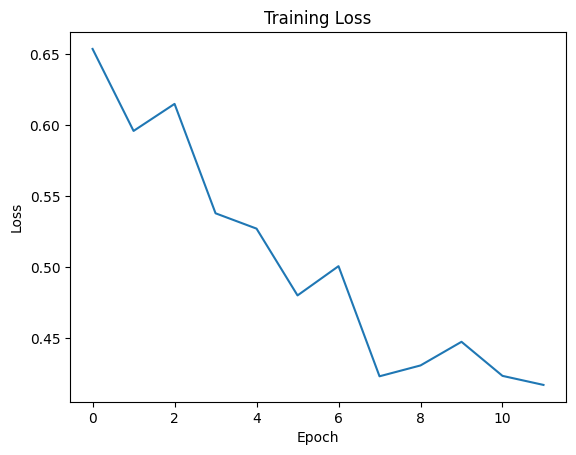

----- Model Evaluation -----
Test accuracy: 1020 / 1131 (90%)


90.18567639257294

In [ ]:
num_epochs = 12
train(model, criterion, train_loader, optimizer, num_epochs=num_epochs)
test(model, valid_loader)

In [ ]:
# print(percent)

In [ ]:
# # Plot the losses.
# plt.plot(losses)
# plt.plot(avg_loss)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.show()


NameError: name 'losses' is not defined

In [ ]:

#     # Plot the loss curves.
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(val_losses, label='Val Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

In [ ]:
# import torch
# import torchvision.models as models
# import torchvision.transforms as transforms
# from PIL import Image

# class ResNextModel(torch.nn.Module):
#     def __init__(self):
#         super(ResNextModel, self).__init__()
#         self.model = models.resnext50_32x4d(pretrained=True)
#         self.model.eval()
        
#     def forward(self, x):
#         with torch.no_grad():
#             output = self.model(x)
#         return output

# class ViTModel(torch.nn.Module):
#     def __init__(self):
#         super(ViTModel, self).__init__()
#         self.model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
#         self.model.eval()
        
#     def forward(self, x):
#         with torch.no_grad():
#             output = self.model(x)
#         return output

# class EfficientNetModel(torch.nn.Module):
#     def __init__(self):
#         super(EfficientNetModel, self).__init__()
#         self.model = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'tf_efficientnet_b4_ns', pretrained=True)
#         self.model.eval()
        
#     def forward(self, x):
#         with torch.no_grad():
#             output = self.model(x)
#         return output

# class MobileNetModel(torch.nn.Module):
#     def __init__(self):
#         super(MobileNetModel, self).__init__()
#         self.model = models.mobilenet_v3_large(pretrained=True)
#         self.model.eval()
        
#     def forward(self, x):
#         with torch.no_grad():
#             output = self.model(x)
#         return output

# # Load and preprocess the image
# image_path = 'path_to_your_image.jpg'
# image = Image.open(image_path).convert('RGB')
# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# input_tensor = transform(image)
# input_batch = input_tensor.unsqueeze(0)

# # Create instances of the models
# resnext_model = ResNextModel()
# vit_model = ViTModel()
# efficientnet_model = EfficientNetModel()
# mobilenet_model = MobileNetModel()

# # Pass the input through both models and get the outputs
# resnext_output = resnext_model(input_batch)
# vit_output = vit_model(input_batch)
# efficientnet_output = efficientnet_model(input_batch)
# mobilenet_output = mobilenet_model(input_batch)

# # Calculate the mean of the outputs
# mean_output = (resnext_output + vit_output) / 2

# # Calculate the sum of the EfficientNet and MobileNet outputs
# sum_output = efficientnet_output + mobilenet_output

# # Apply argmax to obtain the final predictions
# mean_predictions = torch.argmax(mean_output, dim=1)
# sum_predictions = torch.argmax(sum_output, dim=1)

# print("Mean Predictions:", mean_predictions)
# print("Sum Predictions:", sum_predictions)


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_image.jpg'

In [ ]:
import numpy as np

def predict(model, test_loader):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    predictions = []
    #print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        
        # Loop over test data.
        for features, target in test_loader:
            model.to(device)
          
            # Forward pass.
            output = model(features.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            predictions.extend(pred.cpu().data.numpy())
    return predictions

In [ ]:
preds = predict(model, test_loader)

In [ ]:
name = [test_data.file_list[i][-1].split('/')[-1] for i in range(len(test_data.file_list)) ]

In [ ]:
import pandas as pd
sample = pd.read_csv('/kaggle/input/ammi-2023-convnets/sample_submission_file.csv')
sample['Id'] = name

In [ ]:
mapping = {0: 'cmd', 1: 'cbb', 2: 'cbsd', 3: 'healthy', 4: 'cgm'}
new_preds = [mapping[int(pred)] for pred in preds]
sample['Category'] = new_preds
sample.to_csv('submission_whith_90.csv', index=False)
sample.head()

,Category,Id
0,cgm,test-img-1448.jpg
1,cmd,test-img-768.jpg
2,cmd,test-img-3481.jpg
3,cmd,test-img-1475.jpg
4,cgm,test-img-2498.jpg
